## Import packages

In [1]:
# First import matplotlib (for plotting) and skan
from matplotlib import pyplot as plt
%matplotlib inline
from skan import draw
import numpy as np
from skimage import exposure 

# Then import the radial hydride packagess
from HAPPY import import_image
from HAPPY import cropping_functions as crop
from HAPPY import plot_functions as plt_f
from HAPPY import radial_hydride_fraction as RHF
from HAPPY import branching as branch
from HAPPY import crack_path as cp
from HAPPY import image_processing

/Users/miamaric/opt/anaconda3/lib/python3.8/site-packages/skan/csr.py:21: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @numba.jitclass(csr_spec)


## Importing Image

- First, import the image using the `import_image` command. Transpose the image if necessary using the `transpose` argument to make the radial direction vertical. 
- The `cropImage` function applies a rectangular crop to the image to remove scale bars, or if you have a specific rectangular region you want to look at. 
- Input Scale Bar Value in Scale_Bar_Micron_Value, the scale bar will then be calculated.

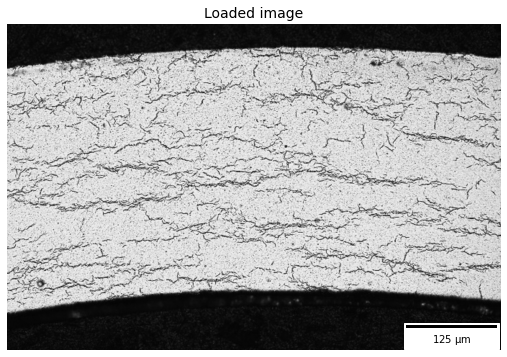

In [2]:
# Load image
original_image = import_image.image(image_path ='560/560-2B.png', transpose = False)
cropped_image = crop.cropImage(original_image, crop_bottom=50, crop_top=0, crop_left=0, crop_right=0)
crop1 = cropped_image
# Input the value of the scale bar in microns
Scale_Bar_Micron_Value = 100
#Input how many pixels are in your scale bar
Pixels_In_Scale_Bar = 165.5
Scale_Bar_Value_In_Meters = Scale_Bar_Micron_Value*(1e-6)
scale = Scale_Bar_Value_In_Meters/Pixels_In_Scale_Bar 
scale_um = scale*1e6
location = 'lower right'


# Plot image
plt_f.plot(img=cropped_image, title='Loaded image',scale=scale, location=location)


## Additional Cropping

The second crop function is `cropping_tube`, which should be used if the micrograph is curved and removes black pats of the image which are not the tube.

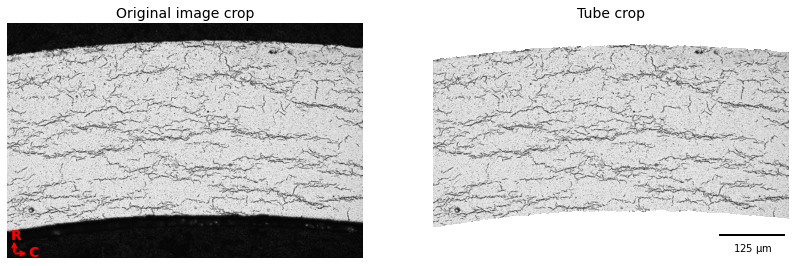

In [3]:
# Crop tube
cropped_image, crop_threshold = crop.cropping_tube(cropped_image, 
                                                   crop_param = 0.2, size_param = 1000, dilation_param = 10)

# Plot comparison
plt_f.plot_comparison(crop1, 'Original image crop', cropped_image, 'Tube crop',scale=scale, 
                   location=location)

## Image Processing

Grain contast or uneven lighting can be minimised through the application of a gaussian blur in the `minimize_grain_contrast` function.

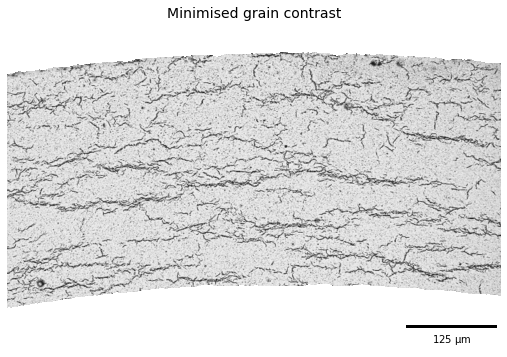

Approximate threshold: 0.936


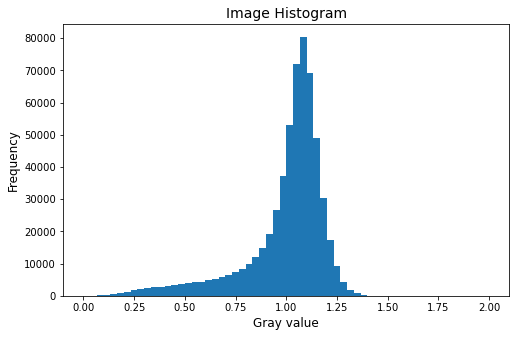

In [4]:
# Remove grain contrast
removed_grains = image_processing.minimize_grain_contrast(cropped_image, sigma = 10)

# Plot image
plt_f.plot(img=cropped_image, title='Minimised grain contrast', scale=scale, location=location)

# Plot the histogram for removed grains so that we can see where we should threshold 
histogram = plt_f.plot_hist(removed_grains)

# Print an approximate threshold value which should work well
print('Approximate threshold: {0:.3f}'.format(
    2*np.nanmedian(removed_grains)-np.nanpercentile(removed_grains, 90)))

## Thresholding

After this, the image is thresholded using the `simple_threshold` function. The threshold value should be set using the `threshold` argument. Small features, less than a given size in microns `small_obj` can optionally be removed. Note it is important not too over threshold the image, guidance of a value to threshold is shown above and can be determined by investigating the histograms plotted above.

/Users/miamaric/Desktop/HAPPy/HAPPY/image_processing.py:86: RuntimeWarning: invalid value encountered in less
  thres = image < threshold


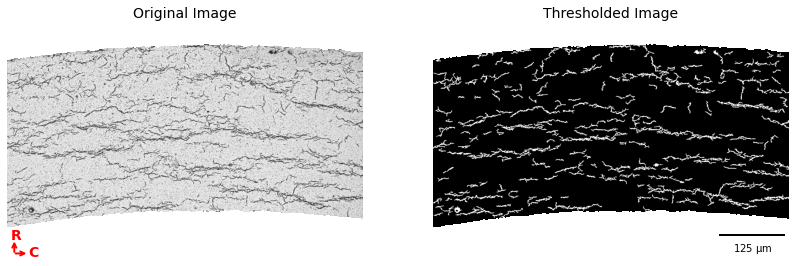

In [5]:
# Apply threshold
thres = image_processing.simple_threshold(removed_grains,scale_um, crop_threshold, 
                                          threshold = 0.85, small_obj = 40)

# Plot the thresholded image and compare it to the original image: 
plt_f.plot_comparison(cropped_image, 'Original Image', thres,'Thresholded Image', scale=scale,location=location)


The first step is to perform the hough line transform `hough_rad` there are a few input parameters that should be considered: 
- `num_peaks`: should be changed dependent on the type of micrograph, if your hydrides are straight and not very interconnected a small value of around 2 is good, if in one box, there are many branches that need to be picked up, this value should be increased accordingly.
- `min_dist`, `min_angle` and `val` are pre-set and seem to work for most cases.
        

/Users/miamaric/Desktop/HAPPy/HAPPY/radial_hydride_fraction.py:65: RuntimeWarning: invalid value encountered in greater
  label, num_features = ndimage.label(image > 0.1)


Number of detected angles: 288


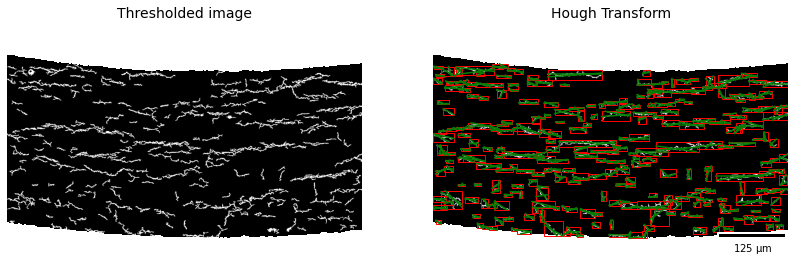

In [6]:
# Apply Hough transform
angle_list,len_list = RHF.hough_rad(thres, num_peaks=2, scale=scale, location=location)

In [7]:
#Non weighted radial hydride fraction
radial, circumferential = RHF.RHF_no_weighting_factor(angle_list, len_list)

print('The non-weighted RHF  is {0:.4f}'.format(radial))

The non-weighted RHF  is 0.0737


In [8]:
#Weighted Radial Hydride Fraction 
fraction = RHF.weighted_RHF_calculation(angle_list, len_list)

print('The weighted RHF is: {0:.4f}'.format(fraction))

The weighted RHF is: 0.1011


## Other Methods for Radial Hydride Fraction Calculation

Here all four different RHF calculation methods are shown in the graph

In [12]:
#chu radial hydride calculation
deg_angle_list = np.rad2deg(angle_list)

radial_list_chu=[]
circum_list_chu = []

for k in deg_angle_list:
    if (k>0 and k<40) or (k>-40 and k<0) :
        radial_list_chu.append(len_list)
    elif (k>50 and k<90) or (k>-90 and k<-50):
        circum_list_chu.append(len_list)
  

rad_hyd_chu = np.sum(radial_list_chu)
cir_hyd_chu = np.sum(circum_list_chu)


RHFChu = rad_hyd_chu/(rad_hyd_chu+cir_hyd_chu)


#RHF 40 deg
radial_list_40=[]
circum_list_40 = []

for k in deg_angle_list:
    if (k>0 and k<40) or (k>-40 and k<0) :
        radial_list_40.append(len_list)
    elif (k>=40 and k<90) or (k>-90 and k<=-40):
        circum_list_40.append(len_list)
  

rad_hyd_40 = np.sum(radial_list_40)
cir_hyd_40 = np.sum(circum_list_40)


RHF40 = rad_hyd_40/(rad_hyd_40+cir_hyd_40)

import pandas as pd 
# intialise data of lists.
data = {"RHF": [RHF40,radial,fraction,RHFChu]
       }
 
# Create DataFrame
df = pd.DataFrame(data,index=["40 Degrees", "45 Degrees", "Weighted", "Chu"])
display(df)

#d = {"one": [1.0, 2.0, 3.0, 4.0], "two": [4.0, 3.0, 2.0, 1.0]}



,RHF
40 Degrees,0.075145
45 Degrees,0.073656
Weighted,0.101096
Chu,0.088235


## Branch Length Fraction

Here we want to determine the extent of branching within the microstrucutre, this is done in two ways: 
- In image form where the branches are coloured differently to the main hydride
- BLF the length fraction of branches with respect to the toatal length of all hydrides in the microstrucutre

The BLF is: 0.2324


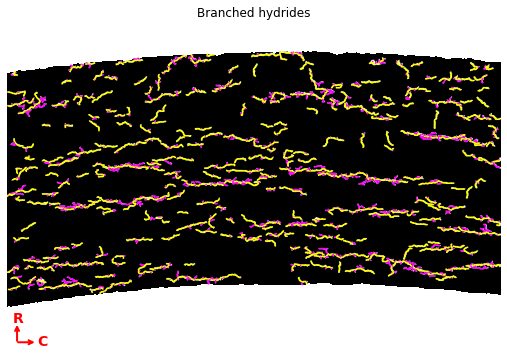

In [13]:
# Calculate the branch length fraction
skel,is_main,BLF = branch.branch_classification(thres);


# Plot branching image
fig, ax = plt.subplots(figsize=(10,6))
ax = draw.overlay_skeleton_2d_class(
    skel,
    skeleton_color_source=lambda s: is_main,
    skeleton_colormap='spring',
    axes=ax
     )

plt.axis('off')
plt.title('Branched hydrides')
#plt_f.addScaleBar(ax[0], scale=scale, location=location)
plt_f.addArrows(ax[0])

print('The BLF is: {0:.4f}'.format(BLF))

## Crack Path

Here we want to determine potential crack paths through the microstrucutre, we input the thresholded image `thres`. After running once, the area around that path (radius set with `kernel_size`) is discounted, then the process is repeated `num_runs` times. Here the `distance_weight` makes moving in the circumferential direction more costly, note when comparing different micrographs, ensure that this parameter it is kept constant.

In [105]:
# Determing potential crack paths
edist, path_list, cost_list = cp.det_crack_path(thres, crop_threshold, num_runs=5, kernel_size=20,distance_weight=1.5)

Run #0	Cost = 2551.34
Run #1	Cost = 2597.42
Run #2	Cost = 2808.68
Run #3	Cost = 3284.08
Run #4	Cost = 3481.29


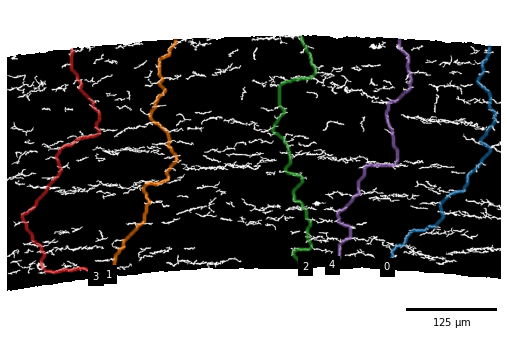

In [106]:
# Plot possible crack paths
fig, ax = plt.subplots(figsize=(10,6))
list_costs = []

for n, (p, c) in enumerate(zip(path_list, cost_list)):
    
    im = ax.imshow(thres, cmap='gray')
    
    #if n==0:
      #  plt.colorbar(im,fraction=0.03, pad=0.01)
    ax.scatter(p[:,1], p[:,0], s=10, alpha=0.1)
    ax.text(p[-1][1], p[-1][0], s=str(n), c='w', bbox=dict(facecolor='black', edgecolor='black'))
    plt.axis('off')
    print('Run #{0}\tCost = {1:.2f}'.format(n,c))
    list_costs.append(c)
    
plt_f.addScaleBar(ax, scale=scale, location=location)
plt_f.addArrows(ax)

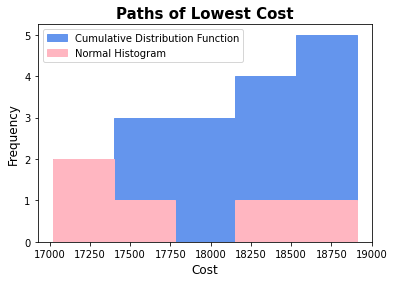

In [45]:
# Histograms for plotting the costs of each path
plt.hist(list_costs, bins=5, cumulative = True, color = "cornflowerblue", ec="cornflowerblue", label = "Cumulative Distribution Function")
plt.hist(list_costs, bins=5, color = "lightpink", ec="lightpink", label = "Normal Histogram")
plt.legend()
plt.xlabel('Cost', fontsize="12")
plt.ylabel('Frequency',fontsize="12")
plt.title('Paths of Lowest Cost', fontweight="bold", fontsize="15")
plt.show()

You can chose to skeletonize the image if you want, not reccomended unless there are too many hydrides to be able to distinguish between them. 


(-0.5, 1109.5, 733.5, -0.5)

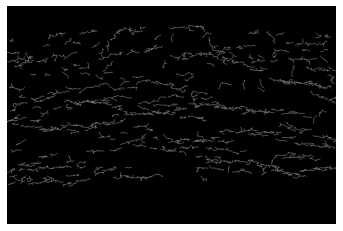

In [14]:
from skimage.morphology import skeletonize
skeletonised = skeletonize(thres)
plt.imshow(skeletonised,cmap='gray')
plt.axis('off')



